In [31]:
using Pkg; Pkg.activate("..")
using Revise
using GraphFusedLasso
using Distributions
using Random
using RCall

In [32]:
R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


In [33]:
Random.seed!(418916)
# 489613

MersenneTwister(UInt32[0x00066464], Random.DSFMT.DSFMT_state(Int32[1027274736, 1072880807, 1911739755, 1072763420, 1654741845, 1072747073, 1498418597, 1073613876, 1884067894, 1072844491  …  -1719540820, 1072722596, 1264495888, 1073061082, -1781459441, 282024113, 1066848294, -295414804, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[34]:4
└ @ Core In[34]:4
┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[34]:6
└ @ Core In[34]:6


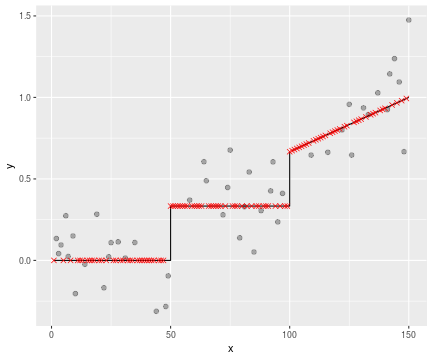

RObject{VecSxp}


In [34]:
# data generation

N = 150

x1 = collect(range(1, 2N ÷ 3))
x2 = collect(range(2N ÷ 3 + 1, N))
x = [x1; x2]
y1 = 50.0floor.(x1 / 50) ./ N
y2 = x2 ./ N
y_true = [y1; y2]
ϵ = rand(Normal(0., 0.1), N)
y_noise = y_true + 2ϵ

p_miss = 0.66
mask = rand(Bernoulli(1 - p_miss), N)
mask = Bool.(mask)
mask[N - 1] = false
mask[N] = true

y = [mi ? yi : missing for (yi, mi) in zip(y_noise, mask)]
y_obs = y[mask]
x_obs = x[mask]

y_miss = y_true[.!mask]
x_miss = x[.!mask]

ptr = collect(1:N)
brks = [1, N + 1]

R"""
d1 = data.frame(x=$x1, y=$y1)
d2 = data.frame(x=$x2, y=$y2)
dobs = data.frame(x=$x_obs, y=$y_obs)
dmiss = data.frame(x=$x_miss, y=$y_miss)

ggplot() +
    geom_step(data=d1, aes(x=x, y=y)) + 
    geom_line(data=d2, aes(x=x, y=y)) +
    geom_point(data=dobs, aes(x=x, y=y), size=2, alpha=0.3) +
    geom_point(data=dmiss, aes(x=x, y=y), size=2, color="red", shape=4)
"""

In [35]:
# function for cross-validation fit

function generate_cvsets(y, nsplits)
    # make the cv splits
    N = length(y)
    cvsets = [Set{Int}() for i in 1:nsplits]
    iobs = shuffle([i for (i, yi) in enumerate(y) if !ismissing(yi)])
    Nobs = length(iobs)
    splitsize = Nobs ÷ nsplits
    for k in 1:nsplits
        for i in ((k - 1) * splitsize + 1):(k * splitsize)
            push!(cvsets[k], iobs[i])
        end
    end
    return cvsets
end

                
function cv_fit(y, ptr, brks, lambdas, cvsets)
    # for each cv split get the mse error
    N = length(y)
    nsplits = length(cvsets)
    nlambdas = length(lambdas)
    mse = zeros(nlambdas)
    mae = zeros(nlambdas)
    for (k, (λ1, λ2)) in enumerate(lambdas)
        for i in 1:nsplits
            # get the cv vector with missing data
            ytrain = [j in cvsets[i] ? missing : yi
                      for (j, yi) in enumerate(y)]

            # fit the model
            lambdasl1 = fill(λ1, N)
            lambdasl2 = fill(λ2, N)
            model = FilterEnet(
                ptr, brks, lambdasl1, lambdasl2;
                prior_mean=0.0, prior_weight=1e-3,
                abstol=0.0, reltol=1e-7)

            fit!(model, ytrain; steps=1000)
            yhat = predict(model)
                            
            # compute the out-of-sample error
            ytest = y[collect(cvsets[i])]
            yhat_test = yhat[collect(cvsets[i])]
                            
            mse[k] += mean((ytest - yhat_test) .^ 2) / nsplits
            mae[k] += mean(abs.(ytest - yhat_test)) / nsplits
        end
    end

    # now choose the best lambdas
    best_lambdas_mse = lambdas[argmin(mse)]
    best_mse = minimum(mse)
    best_lambdas_mae = lambdas[argmin(mae)]
    best_mae = minimum(mae)

    # train best for mse
    lambdasl1 = fill(best_lambdas_mse[1], N)
    lambdasl2 = fill(best_lambdas_mse[2], N)
    model = FilterEnet(
                ptr, brks, lambdasl1, lambdasl2;
                prior_mean=0.0, prior_weight=1e-3,
                abstol=0.0, reltol=1e-7)
    fit!(model, y; steps=1000)
    yhat_mse = predict(model)

    # train best for mae
    lambdasl1 = fill(best_lambdas_mae[1], N)
    lambdasl2 = fill(best_lambdas_mae[2], N)
    model = FilterEnet(
                ptr, brks, lambdasl1, lambdasl2;
                prior_mean=0.0, prior_weight=1e-3,
                abstol=0.0, reltol=1e-7)
    fit!(model, y; steps=1000)
    yhat_mae = predict(model)

    return Dict("best_lambdas_mse" => best_lambdas_mse,
                "best_lambdas_mae" => best_lambdas_mae,
                "yhat_mse" => yhat_mse,
                "yhat_mae" => yhat_mae,
                "best_rmse" => sqrt(best_mse),
                "best_mae" => best_mae,
                "mse" => mse,
                "mae" => mae,
                "cvsets" => cvsets)
end

cv_fit (generic function with 1 method)

In [36]:
nsplits = 5
cvsets = generate_cvsets(y, nsplits)

5-element Array{Set{Int64},1}:
 Set([133, 9, 10, 83, 58, 72, 49, 79, 142])  
 Set([125, 116, 74, 93, 64, 109, 97, 144, 6])
 Set([4, 75, 35, 3, 126, 137, 48, 141, 85])  
 Set([92, 25, 31, 2, 65, 95, 150, 44, 22])   
 Set([7, 14, 148, 81, 122, 131, 28, 19, 88]) 

Dict{String,Any} with 9 entries:
  "best_lambdas_mae" => (0.55102, 1.0e-12)
  "yhat_mae"         => [0.0462483, 0.0462483, 0.0462483, 0.0462483, 0.0462483,…
  "yhat_mse"         => [0.0428576, 0.0428576, 0.0428576, 0.0428576, 0.0428576,…
  "best_mae"         => 0.181303
  "best_lambdas_mse" => (0.489796, 1.0e-12)
  "best_rmse"        => 0.222482
  "mse"              => [0.336616, 0.0617328, 0.0549477, 0.051837, 0.0514393, 0…
  "cvsets"           => Set{Int64}[Set([133, 9, 10, 83, 58, 72, 49, 79, 142]), …
  "mae"              => [0.452582, 0.201775, 0.187006, 0.183677, 0.184491, 0.18…

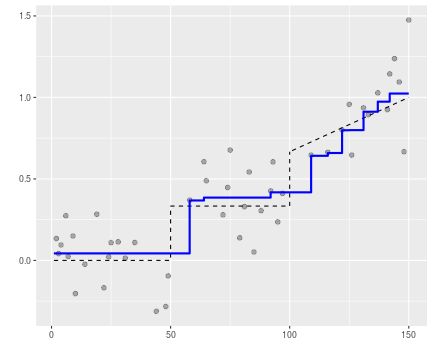

RObject{VecSxp}


In [37]:
# compute the fused lasso best
lambdas = [(l, 1e-12) for l in range(1e-12, 3.0, length=50)]
results_fl = cv_fit(y, ptr, brks, lambdas, cvsets)
yhat_fl = results_fl["yhat_mse"]

display(results_fl)

R"""
d1 = data.frame(x=$x1, y=$y1)
d2 = data.frame(x=$x2, y=$y2)
dobs = data.frame(x=$x_obs, y=$y_obs)
dfit = data.frame(x=$x, y=$yhat_fl)
dmiss = data.frame(x=$x_miss, y=$y_miss)
ggplot() +
    geom_step(data=d1, aes(x=x, y=y), linetype="dashed") + 
    geom_line(data=d2, aes(x=x, y=y), linetype="dashed") +
    geom_point(data=dobs, aes(x=x, y=y), size=2, alpha=0.3) +
    geom_step(data=dfit, aes(x=x, y=y), color="blue", size=1) +
    labs(x="", y="") +
    ggsave("benchmarks_linear_fl.png", units="cm", width=12, height=7)
"""

Dict{String,Any} with 9 entries:
  "best_lambdas_mae" => (1.0e-12, 8.08081)
  "yhat_mae"         => [0.0967888, 0.0968007, 0.0922059, 0.0939125, 0.0955236,…
  "yhat_mse"         => [0.0907706, 0.090777, 0.0877246, 0.0879558, 0.0877107, …
  "best_mae"         => 0.156098
  "best_lambdas_mse" => (1.0e-12, 14.1414)
  "best_rmse"        => 0.203541
  "mse"              => [0.336616, 0.0537424, 0.0505361, 0.0485234, 0.0470912, …
  "cvsets"           => Set{Int64}[Set([133, 9, 10, 83, 58, 72, 49, 79, 142]), …
  "mae"              => [0.452582, 0.179889, 0.171829, 0.166763, 0.163325, 0.16…

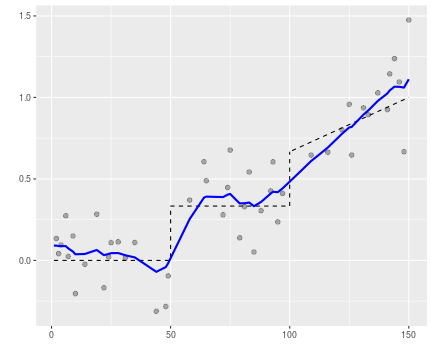

RObject{VecSxp}


In [38]:
# compute the kalman filter best
lambdas = [(1e-12, l) for l in range(1e-12, 50.0, length=100)]
results_kal = cv_fit(y, ptr, brks, lambdas, cvsets)
yhat_kal = results_kal["yhat_mse"]

display(results_kal)

R"""
d1 = data.frame(x=$x1, y=$y1)
d2 = data.frame(x=$x2, y=$y2)
dobs = data.frame(x=$x_obs, y=$y_obs)
dfit = data.frame(x=$x, y=$yhat_kal)
dmiss = data.frame(x=$x_miss, y=$y_miss)
ggplot() +
    geom_step(data=d1, aes(x=x, y=y), linetype="dashed") + 
    geom_line(data=d2, aes(x=x, y=y), linetype="dashed") +
    geom_point(data=dobs, aes(x=x, y=y), size=2, alpha=0.3) +
    geom_line(data=dfit, aes(x=x, y=y), color="blue", size=1) +
    labs(x="", y="") +
    ggsave("benchmarks_linear_kal.png", units="cm", width=12, height=7)
"""


Dict{String,Any} with 9 entries:
  "best_lambdas_mae" => (0.0204082, 6.53061)
  "yhat_mae"         => [0.0988367, 0.0988367, 0.0965885, 0.0965885, 0.0968514,…
  "yhat_mse"         => [0.0510917, 0.0510917, 0.0510917, 0.0510917, 0.0510917,…
  "best_mae"         => 0.15604
  "best_lambdas_mse" => (0.346939, 6.93878)
  "best_rmse"        => 0.202524
  "mse"              => [0.336616, 0.0546556, 0.0515604, 0.0495875, 0.0481495, …
  "cvsets"           => Set{Int64}[Set([133, 9, 10, 83, 58, 72, 49, 79, 142]), …
  "mae"              => [0.452582, 0.182184, 0.174415, 0.169408, 0.165884, 0.16…

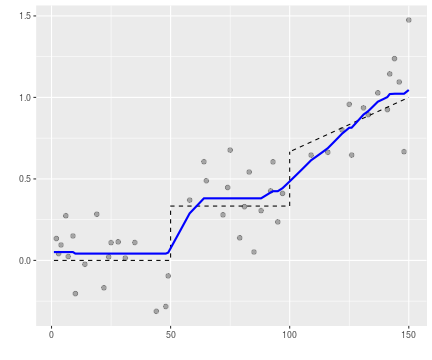

RObject{VecSxp}


In [39]:
# compute the gfenet best
lambdas = [(l1, l2) for l1 in range(1e-12, 1.0, length=50)
                    for l2 in range(1e-12, 20.0, length=50)]
results_enet = cv_fit(y, ptr, brks, lambdas, cvsets)
yhat_enet = results_enet["yhat_mse"]
            
display(results_enet)

R"""
d1 = data.frame(x=$x1, y=$y1)
d2 = data.frame(x=$x2, y=$y2)
dobs = data.frame(x=$x_obs, y=$y_obs)
dfit = data.frame(x=$x, y=$yhat_enet)
ggplot() +
    geom_step(data=d1, aes(x=x, y=y), linetype="dashed") + 
    geom_line(data=d2, aes(x=x, y=y), linetype="dashed") +
    geom_point(data=dobs, aes(x=x, y=y), size=2, alpha=0.3) +
    geom_line(data=dfit, aes(x=x, y=y), color="blue", size=1) +
    labs(x="", y="") +
    ggsave("benchmarks_linear_enet.png", units="cm", width=12, height=7)
"""
